In [335]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from pathlib import Path
%matplotlib inline

## Data Retreival/Formatting

In [336]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [337]:
# type(alpaca_api_key)

In [338]:
crypto_client = CryptoHistoricalDataClient()

In [339]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Hour, start='2021-01-01 00:00:00'
)

btc_bars = crypto_client.get_crypto_bars(request_params)

btc_df = btc_bars.df

btc_df

open     high      low    close  \
symbol  timestamp                                                       
BTC/USD 2021-01-01 00:00:00+00:00  28973.0  29073.5  28775.0  29065.0   
        2021-01-01 01:00:00+00:00  29070.0  29481.0  29038.5  29404.5   
        2021-01-01 02:00:00+00:00  29528.0  29528.0  29218.0  29245.0   
        2021-01-01 03:00:00+00:00  29400.5  29400.5  29337.0  29367.5   
        2021-01-01 04:00:00+00:00  29449.0  29449.0  29136.5  29189.5   
...                                    ...      ...      ...      ...   
        2022-10-05 21:00:00+00:00  19989.0  20093.0  19989.0  20056.0   
        2022-10-05 22:00:00+00:00  20060.0  20212.0  20023.0  20192.0   
        2022-10-05 23:00:00+00:00  20192.0  20195.0  20119.0  20163.0   
        2022-10-06 00:00:00+00:00  20163.0  20383.0  20151.0  20276.0   
        2022-10-06 01:00:00+00:00  20275.0  20337.0  20250.0  20283.0   

                                     volume  trade_count          vwap  
symbol  timestamp                                                       
BTC/USD 2021-01-01 00:00:00+00:00    3.4437         72.0  28968.839097  
        2021-01-01 01:00:00+00:00    4.6183         65.0  29359.399487  
        2021-01-01 02:00:00+00:00    4.3423         42.0  29361.540923  
        2021-01-01 03:00:00+00:00    0.3089          3.0  29400.447394  
        2021-01-01 04:00:00+00:00    2.0245         34.0  29302.743369  
...                                     ...          ...           ...  
        2022-10-05 21:00:00+00:00   69.2090        475.0  20044.197130  
        2022-10-05 22:00:00+00:00  133.3761        704.0  20124.529345  
        2022-10-05 23:00:00+00:00   42.3767        606.0  20156.381837  
        2022-10-06 00:00:00+00:00  235.6275       1328.0  20290.158078  
        2022-10-06 01:00:00+00:00   72.6605        489.0  20288.934980  

[15412 rows x 7 columns]

In [340]:
btc_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [341]:
btc_df = btc_df.reset_index()
btc_df = btc_df.set_index('timestamp')
btc_df = btc_df.drop(columns=['symbol'])

btc_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2021-01-01 00:00:00+00:00,28973.0,29073.5,28775.0,29065.0,3.4437,72.0,28968.839097
2021-01-01 01:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0,29359.399487
2021-01-01 02:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0,29361.540923
2021-01-01 03:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0,29400.447394
2021-01-01 04:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0,29302.743369
...,...,...,...,...,...,...,...
2022-10-05 21:00:00+00:00,19989.0,20093.0,19989.0,20056.0,69.2090,475.0,20044.197130
2022-10-05 22:00:00+00:00,20060.0,20212.0,20023.0,20192.0,133.3761,704.0,20124.529345
2022-10-05 23:00:00+00:00,20192.0,20195.0,20119.0,20163.0,42.3767,606.0,20156.381837


In [342]:
# # Use the pct_change function to generate  returns from close prices
# btc_df["Actual Returns"] = btc_df["close"].pct_change()

# # Drop na
# btc_df=btc_df.dropna()

In [343]:
# Assign a copy of features to a DataFrame called X
X = btc_df[['open', 'high','low','volume', 'trade_count']].shift().dropna()
# Review the DataFrame
X.head()

,open,high,low,volume,trade_count
timestamp,,,,,
2021-01-01 01:00:00+00:00,28973.0,29073.5,28775.0,3.4437,72.0
2021-01-01 02:00:00+00:00,29070.0,29481.0,29038.5,4.6183,65.0
2021-01-01 03:00:00+00:00,29528.0,29528.0,29218.0,4.3423,42.0
2021-01-01 04:00:00+00:00,29400.5,29400.5,29337.0,0.3089,3.0
2021-01-01 05:00:00+00:00,29449.0,29449.0,29136.5,2.0245,34.0


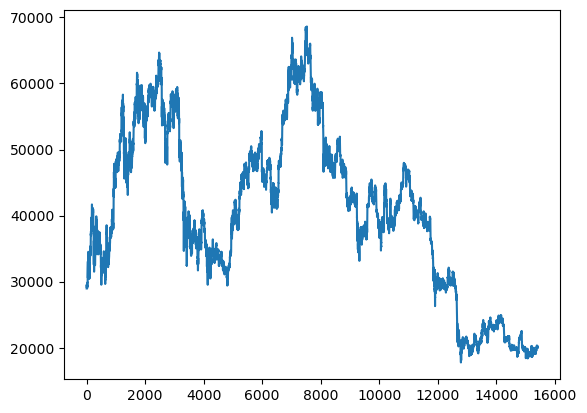

In [344]:
plt.plot(range(len(X)), X[['open']])

In [345]:
scaler=StandardScaler()

# Fit the scaler to the features training dataset
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-0.91841739, -0.92348641, -0.92023323, -0.57659369, -0.56131615],
       [-0.91068628, -0.89113081, -0.89913455, -0.56503155, -0.58014694],
       [-0.87418269, -0.887399  , -0.88476183, -0.56774835, -0.64201952],
       ...,
       [-1.62880278, -1.62709169, -1.62101358,  0.7023922 ,  1.13883478],
       [-1.61828209, -1.62844149, -1.61332678, -0.19335781,  0.87520378],
       [-1.62059345, -1.61351425, -1.61076451,  1.70890095,  2.81746481]])

### Data Split for Training

In [346]:
# get array representation of dataframe
dataset = btc_df.values

# get number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

12330

In [347]:
# create train dataset
train_data = X_scaled[0:training_data_len, :]

# Create blank array
X_train = []
candles = 60

for i in range(candles, len(train_data)):
    X_train.append(train_data[i-candles:i, 0:6])


# create test dataset
test_data = X_scaled[training_data_len - candles: , :]

# Create blank array
X_test = []

for i in range(candles, len(test_data)):
    X_test.append(test_data[i-candles:i, 0:6])


In [348]:
# Convert lists to array

X_train = np.array(X_train)
X_test = np.array(X_test)

display(X_train.shape)
display(len(X_train))
display(len(X_test))

X_test


(12270, 60, 5)

12270

3081

array([[[-0.91602633, -0.92868713, -0.92143429, -0.52894046,
          0.45823638],
        [-0.93164795, -0.92789312, -0.91951259, -0.11763199,
          0.55777053],
        [-0.92495297, -0.90597866, -0.91550904, -0.02602864,
          1.22222825],
        ...,
        [-0.90590415, -0.91701529, -0.8982938 ,  1.72599217,
          0.18384493],
        [-0.91004866, -0.91828569, -0.89709274, -0.25083286,
         -0.58552716],
        [-0.90446951, -0.91352168, -0.89132764,  0.20022552,
         -0.35686762]],

       [[-0.93164795, -0.92789312, -0.91951259, -0.11763199,
          0.55777053],
        [-0.92495297, -0.90597866, -0.91550904, -0.02602864,
          1.22222825],
        [-0.89753542, -0.89970604, -0.89356962,  1.68676692,
          2.38973696],
        ...,
        [-0.91004866, -0.91828569, -0.89709274, -0.25083286,
         -0.58552716],
        [-0.90446951, -0.91352168, -0.89132764,  0.20022552,
         -0.35686762],
        [-0.900325  , -0.88461999, -0.89012658, 

In [349]:
# Create the target set selecting the Signal column and assiging it to y
y = btc_df['close']

# Review the value counts
display(y)

# Drop first row
# y = y.iloc[1:-candles]
y=y.iloc[candles+1:]

display(y)

timestamp
2021-01-01 00:00:00+00:00    29065.0
2021-01-01 01:00:00+00:00    29404.5
2021-01-01 02:00:00+00:00    29245.0
2021-01-01 03:00:00+00:00    29367.5
2021-01-01 04:00:00+00:00    29189.5
                              ...   
2022-10-05 21:00:00+00:00    20056.0
2022-10-05 22:00:00+00:00    20192.0
2022-10-05 23:00:00+00:00    20163.0
2022-10-06 00:00:00+00:00    20276.0
2022-10-06 01:00:00+00:00    20283.0
Name: close, Length: 15412, dtype: float64

timestamp
2021-01-03 15:00:00+00:00    33553.0
2021-01-03 16:00:00+00:00    32627.5
2021-01-03 17:00:00+00:00    33036.0
2021-01-03 18:00:00+00:00    32772.0
2021-01-03 19:00:00+00:00    32779.0
                              ...   
2022-10-05 21:00:00+00:00    20056.0
2022-10-05 22:00:00+00:00    20192.0
2022-10-05 23:00:00+00:00    20163.0
2022-10-06 00:00:00+00:00    20276.0
2022-10-06 01:00:00+00:00    20283.0
Name: close, Length: 15351, dtype: float64

In [350]:
# Splitting Y data

y_train = y.iloc[0:len(X_train)]
y_test = y.iloc[len(X_train):]

display(y_train.shape)
display(y_test.shape)
display(X_test.shape)
display(X_train.shape)

(12270,)

(3081,)

(3081, 60, 5)

(12270, 60, 5)

## Model Creation

In [351]:
# Define the the number of inputs (features) to the model
number_input_features = len(X.columns)

# Review the number of features
number_input_features


5

In [352]:
# Create the Sequential model instance
regr_nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
# hidden_nodes_layer1 = (number_input_features + 1) // 2
hidden_nodes_layer1 = 64

# Define hidden nodes for all hidden layers
hidden_nodes = math.ceil(((number_input_features+1)*2)/3)
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
# hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

4

64

64

In [353]:
# Add the first hidden layer
regr_nn.add(LSTM(units=hidden_nodes_layer1, return_sequences=True, input_shape=(candles,len(X.columns))))

In [354]:
# # Add dropout layer
regr_nn.add(Dropout(rate=0.2))

In [355]:
#Add the second hidden layer
regr_nn.add(LSTM(units=hidden_nodes_layer2, return_sequences=True))


In [356]:
# # Add dropout layer
regr_nn.add(Dropout(rate=0.2))

In [357]:
# #Add the third hidden layer
regr_nn.add(LSTM(units=hidden_nodes_layer2))

In [358]:
# # Add dropout layer
# regr_nn.add(Dropout(rate=0.2))

In [359]:
# Add Dense layer
# regr_nn.add(Dense(units=6, activation='relu'))

In [360]:
# Add the output layer to the model specifying the number of output neurons and activation function
regr_nn.add(Dense(units=1,  activation='linear'))


In [361]:
# Display the Sequential model summary, subclassed model requires build
regr_nn.build(X_train.shape)
regr_nn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 60, 64)            17920     
_________________________________________________________________
dropout_33 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 60, 64)            33024     
_________________________________________________________________
dropout_34 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 84,033
Trainable params: 84,033
Non-trainable params: 0
_________________________________________________

In [362]:
# Compile the Sequential model

regr_nn.compile(loss='mean_squared_error', optimizer='adam')

In [363]:
# Fit the model using epochs and the training data
regr_model=regr_nn.fit(X_train, y_train, epochs=10, validation_split=.1)

Epoch 1/10
346/346 [==============================] - 35s 101ms/step - loss: 2219087104.0000 - val_loss: 1285928576.0000
Epoch 2/10
346/346 [==============================] - 33s 94ms/step - loss: 2216871936.0000 - val_loss: 1284301696.0000
Epoch 3/10
346/346 [==============================] - 32s 94ms/step - loss: 2214769920.0000 - val_loss: 1282692864.0000
Epoch 4/10
346/346 [==============================] - 34s 97ms/step - loss: 2212678400.0000 - val_loss: 1281090944.0000
Epoch 5/10
346/346 [==============================] - 33s 95ms/step - loss: 2210597120.0000 - val_loss: 1279494272.0000
Epoch 6/10
346/346 [==============================] - 33s 96ms/step - loss: 2208521472.0000 - val_loss: 1277901312.0000
Epoch 7/10
346/346 [==============================] - 33s 96ms/step - loss: 2206448384.0000 - val_loss: 1276311040.0000
Epoch 8/10
346/346 [==============================] - 33s 96ms/step - loss: 2204376320.0000 - val_loss: 1274721664.0000
Epoch 9/10
346/346 [===================

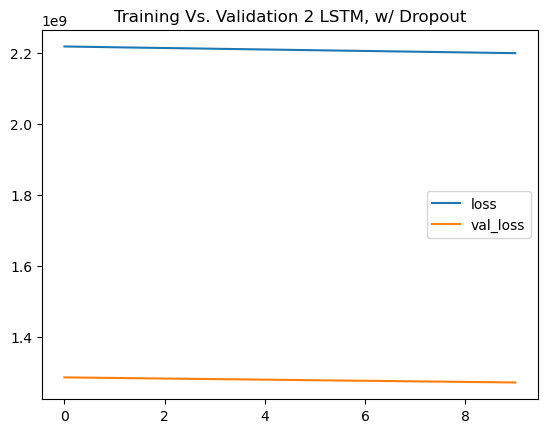

In [364]:
# Train vs test for loss
plt.plot(regr_model.history["loss"])
plt.plot(regr_model.history["val_loss"])
plt.title("Training Vs. Validation 2 LSTM, w/ Dropout")
plt.legend(["loss", "val_loss"])
plt.show()

In [365]:
# Make model predictionis

y_pred=regr_nn.predict(X_test)

y_pred


array([[236.38017],
       [236.38019],
       [236.38017],
       ...,
       [236.38016],
       [236.38017],
       [236.38017]], dtype=float32)

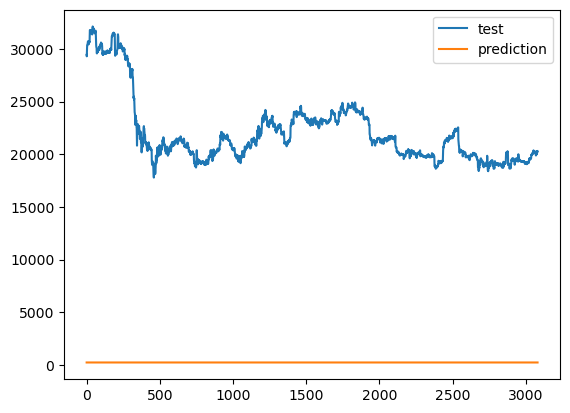

In [366]:
# Plot prediction results
plt.plot(range(len(y_test)), (y_test))
plt.plot(range(len(y_test)), (y_pred))
plt.legend(["test", "prediction"])

In [367]:
# Set the file path for the first regression model
file_path = Path('Models/regr_nn.h5')

# Export your model to a HDF5 file
regr_nn.save(file_path)